In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import pickle

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.preprocessing._encoders')

In [299]:
df = pd.read_csv("../data.csv")
df.sample(5, random_state=1)

,location,voivodship,area,ownership,rooms,floor,outdoor_space,rent,parking,heating,advertiser,construction_year,building,elevator,price
38857,Niepołomice,małopolskie,60.00,pełna własność,3.0,0.0,"ogródek, taras",0.0,1.0,gazowe,biuro nieruchomości,2018.0,blok,0.0,750000.0
18978,Toruń,kujawsko-pomorskie,64.00,pełna własność,3.0,1.0,balkon,690.0,0.0,NaN,biuro nieruchomości,2009.0,NaN,0.0,619000.0
41215,Szczecin,zachodniopomorskie,77.59,pełna własność,3.0,4.0,none,647.0,0.0,miejskie,biuro nieruchomości,1988.0,blok,0.0,475000.0
9133,Warszawa,mazowieckie,19.00,pełna własność,1.0,3.0,none,338.0,0.0,miejskie,biuro nieruchomości,1935.0,kamienica,0.0,480000.0
896,Warszawa,mazowieckie,58.90,pełna własność,2.0,0.0,ogródek,874.0,1.0,kotłownia,biuro nieruchomości,2001.0,blok,1.0,939000.0


In [300]:
df.shape

(56934, 15)

In [301]:
df.describe()

,area,rooms,floor,rent,parking,construction_year,elevator,price
count,5.693400e+04,56934.000000,56104.000000,5.693400e+04,56934.000000,4.085800e+04,56934.000000,5.693400e+04
mean,2.427009e+02,2.603119,2.398011,4.530450e+02,0.378789,3.471760e+03,0.317051,6.635477e+05
std,2.246327e+04,1.010006,2.211031,6.346304e+03,0.485090,1.733440e+05,0.465332,6.810282e+05
min,5.040000e+00,1.000000,-1.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,2.400000e+03
25%,4.300000e+01,2.000000,1.000000,0.000000e+00,0.000000,1.970000e+03,0.000000,3.490000e+05
50%,5.310000e+01,3.000000,2.000000,4.000000e+02,0.000000,1.991000e+03,0.000000,5.300000e+05
75%,6.732000e+01,3.000000,3.000000,6.500000e+02,1.000000,2.016000e+03,1.000000,7.700000e+05
max,3.777480e+06,11.000000,25.000000,1.300000e+06,1.000000,2.023202e+07,1.000000,4.300000e+07


In [302]:
pd.DataFrame({
            'Data Type': df.dtypes,
            'Missing Values count': df.isna().sum(),
            'Missing Values %': round((df.isna().sum() / len(df) * 100),2),
        }).sort_values(by='Missing Values %', ascending=False)

,Data Type,Missing Values count,Missing Values %
construction_year,float64,16076,28.24
ownership,object,13271,23.31
heating,object,10376,18.22
building,object,8097,14.22
floor,float64,830,1.46
location,object,25,0.04
voivodship,object,22,0.04
area,float64,0,0.00
rooms,float64,0,0.00
outdoor_space,object,0,0.00


In [303]:
num = ["construction_year", "floor", "area", "rooms", "rent", "parking", "elevator", "price"]
categ = [col for col in df.columns if col not in num]

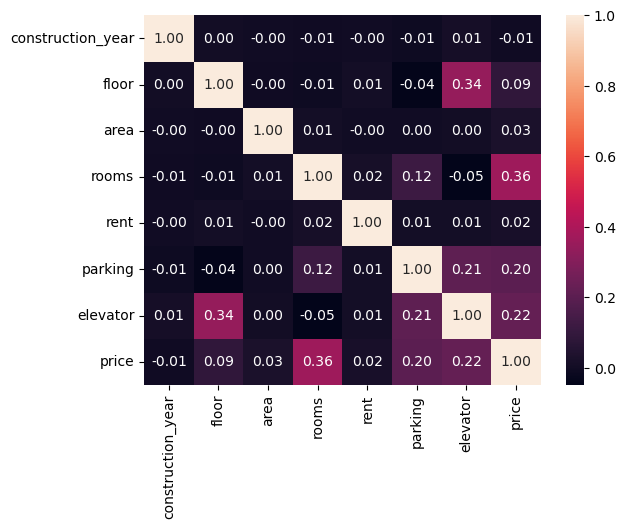

In [304]:
sns.heatmap(df[num].corr(), annot=True, fmt = '.2f')
plt.show()

In [305]:
df = df.drop(["ownership", "advertiser"], axis = 1)
categ.remove("ownership")
categ.remove("advertiser")

df[categ] = df[categ].fillna('missing')
df[["construction_year"]] = df[["construction_year"]].fillna(np.median(df.construction_year.dropna()))
df[["floor"]] = df[["floor"]].fillna(np.median(df.floor.dropna()))

In [306]:
df.isna().sum().sum()

0

In [307]:
def remove_outliers(df):
    df_cleaned = df.copy()
    for col in num:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] > lower_bound) & (df_cleaned[col] < upper_bound)]
    return df_cleaned

print(df.shape)
df = remove_outliers(df)
print(df.shape)


(56934, 13)
(44204, 13)


In [308]:
df.describe()

,area,rooms,floor,rent,parking,construction_year,elevator,price
count,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,4.420400e+04
mean,52.788394,2.434440,1.915551,374.588885,0.360035,1991.309090,0.268935,5.265355e+05
std,15.978860,0.789082,1.428710,327.650434,0.480016,22.027557,0.443411,2.503542e+05
min,7.870000,1.000000,-1.000000,0.000000,0.000000,1928.000000,0.000000,2.400000e+03
25%,41.537500,2.000000,1.000000,0.000000,0.000000,1980.000000,0.000000,3.290000e+05
50%,51.000000,2.000000,2.000000,400.000000,0.000000,1991.000000,0.000000,4.873500e+05
75%,62.570000,3.000000,3.000000,610.000000,1.000000,2010.000000,1.000000,6.890000e+05
max,102.930000,4.000000,5.000000,1550.000000,1.000000,2026.000000,1.000000,1.288710e+06


In [309]:
df = df[df['construction_year'] < 2024]
df = df[df['price'] < 1000000]
df.shape

(40950, 13)

In [310]:
for col in categ:
    print(df[col].unique(), "\n")

['Rybnik' 'Rzeszów' 'Lublin' ... 'Cieszanów' 'Mszana Dolna' 'Turobin'] 

['śląskie' 'podkarpackie' 'lubelskie' 'pomorskie' 'zachodniopomorskie'
 'mazowieckie' 'dolnośląskie' 'małopolskie' 'podlaskie' 'łódzkie'
 'lubuskie' 'kujawsko-pomorskie' 'wielkopolskie' 'warmińsko-mazurskie'
 'opolskie' 'świętokrzyskie' 'missing'] 

['balkon' 'none' 'ogródek' 'taras' 'ogródek, taras' 'balkon, ogródek'
 'balkon, taras' 'balkon, ogródek, taras' 'taras, ogródek' 'taras, balkon'
 'taras, balkon, ogródek' 'balkon, taras, ogródek'] 

['miejskie' 'inne' 'gazowe' 'elektryczne' 'kotłownia' 'piece kaflowe'
 'missing'] 

['blok' 'apartamentowiec' 'kamienica' 'dom wolnostojący' 'szeregowiec'
 'loft' 'plomba' 'missing'] 



In [311]:
def outdoor_space_formating(space):
    if space == 'none':
        return 'none'
    return ', '.join(sorted(space.split(', ')))

df['outdoor_space'] = df['outdoor_space'].apply(outdoor_space_formating)

In [312]:
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


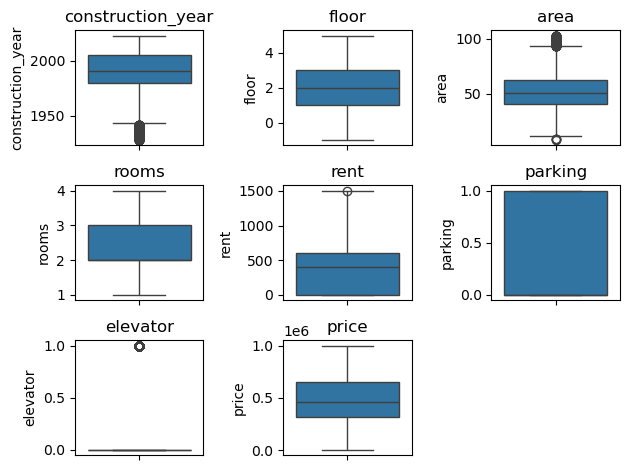

In [313]:
for i, col in enumerate(num, 1):
    plt.subplot(3, 3, i) 
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [314]:
X = df.drop(columns=['price'])
y = df['price']
num.remove("price")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [315]:
print(X_train.shape, X_test.shape)

(32672, 12) (8169, 12)


In [316]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categ])

X_train_encoded = pd.DataFrame(encoder.transform(X_train[categ]), columns=encoder.get_feature_names_out(categ))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categ]), columns=encoder.get_feature_names_out(categ))

X_train = pd.concat([X_train.drop(categ, axis=1).reset_index(drop=True), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(categ, axis=1).reset_index(drop=True), X_test_encoded], axis=1)

In [317]:
scaler = StandardScaler()

X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [318]:
def model_results(y_pred, y_pred_train):    
    r2_val = round(r2_score(y_test, y_pred), 4)
    rmse_val = round(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_val = round(mean_absolute_error(y_test, y_pred))
    
    r2_train = round(r2_score(y_train, y_pred_train), 4)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    mae_train = round(mean_absolute_error(y_train, y_pred_train))
    
    if r2_val < 0:
        r2_val = 0
        rmse_val = 900000
        mae_val = 10000000

    scores.loc[len(scores.index)] = [r2_val, rmse_val, mae_val, r2_train, rmse_train, mae_train]
    return

scores = pd.DataFrame({
    "R^2_val": [],
    "RMSE_val": [],
    "MAE_val": [],
    "R^2_train": [],
    "RMSE_train": [],
    "MAE_train": []
})


In [319]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
y_pred_train = model_lr.predict(X_train)

model_results(y_pred, y_pred_train)

In [320]:
model_ridge = Ridge() 

model_ridge.fit(X_train, y_train)
y_pred = model_ridge.predict(X_test)
y_pred_train = model_ridge.predict(X_train)

model_results(y_pred, y_pred_train)

In [321]:
model_KNN = KNeighborsRegressor(n_neighbors=5)  

model_KNN.fit(X_train, y_train)
y_pred = model_KNN.predict(X_test)
y_pred_train = model_KNN.predict(X_train)

model_results(y_pred, y_pred_train)

In [322]:
model_tree = DecisionTreeRegressor()

model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
y_pred_train = model_tree.predict(X_train)

model_results(y_pred, y_pred_train)

In [323]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
y_pred_train = model_rf.predict(X_train)

model_results(y_pred, y_pred_train)

In [324]:
model_xgb = XGBRegressor()

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
prediction = model_xgb.predict(X_test)
y_pred_train = model_xgb.predict(X_train)

model_results(y_pred, y_pred_train)

In [325]:
from keras.layers import InputLayer, Dense, ReLU, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf
import random
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import HeNormal


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-10)


model_nn = Sequential([
    InputLayer((X_train.shape[1],)),
        
    Dense(1024, kernel_regularizer=l2(0.0001), kernel_initializer=HeNormal()),
    ReLU(),
    Dropout(0.2), 
    
    Dense(512, kernel_regularizer=l2(0.0001), kernel_initializer=HeNormal()),
    ReLU(),
    Dropout(0.2), 
      
    Dense(256, kernel_regularizer=l2(0.0001), kernel_initializer=HeNormal()),
    ReLU(),
    Dropout(0.2),
    
    Dense(1)
])

model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model_nn.fit(X_train, y_train, epochs=100, batch_size=64, 
                       validation_split=0.2, 
                       callbacks=[lr_scheduler]) 
y_pred = model_nn.predict(X_test)
y_pred_train = model_nn.predict(X_train)

model_results(y_pred, y_pred_train)

Epoch 1/100


2024-10-25 15:41:41.803849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


409/409 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 173198196736.0000 - val_loss: 14666552320.0000 - learning_rate: 0.0010
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 14558434304.0000 - val_loss: 10693770240.0000 - learning_rate: 0.0010
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 11414211584.0000 - val_loss: 9419195392.0000 - learning_rate: 0.0010
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 10077832192.0000 - val_loss: 8828405760.0000 - learning_rate: 0.0010
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9528365056.0000 - val_loss: 8586772480.0000 - learning_rate: 0.0010
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9331624960.0000 - val_loss: 8459437056.0000 - learning_rate: 0.0010
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9132027904.0000 - val_loss: 8325263360.0000 - learning_rate: 0.0010
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8822016000.0000 - val_loss: 81940

2024-10-25 15:50:57.744834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step


In [326]:
scores.index = ["Linear", "Ridge", "KNN", "Decision Tree", "RandomForest", "XGBoost", "NN"]
scores.sort_values(by='RMSE_val', ascending=True)

,R^2_val,RMSE_val,MAE_val,R^2_train,RMSE_train,MAE_train
NN,0.8259,89693.0,65282.0,0.8711,77474.0,55131.0
XGBoost,0.8095,93824.0,69220.0,0.8575,81449.0,61003.0
RandomForest,0.7967,96922.0,69418.0,0.9726,35700.0,25512.0
Ridge,0.7860,99442.0,74207.0,0.8092,94237.0,70105.0
KNN,0.6773,122119.0,90072.0,0.7971,97190.0,71791.0
Decision Tree,0.6391,129153.0,91155.0,0.9999,2156.0,126.0
Linear,0.0000,900000.0,10000000.0,0.8111,93777.0,69446.0


In [328]:
model_nn.save('model.keras')

my_data = {'num': num, 
           'categ': categ,
           'encoder': encoder,
           'scaler': scaler}

with open('../web/encoding_vars.pkl', 'wb') as f:
    pickle.dump(my_data, f)